Importing Libraries

In [12]:
from pydriller import Repository
from pydriller import ModificationType
import csv
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import git
from git import GitCommandError
import os

Loading the Repositories

In [ ]:
repos = [
    'https://github.com/AntonOsika/gpt-engineer',
    'https://github.com/binary-husky/gpt_academic',
    'https://github.com/crewAIInc/crewAI'
]

In [14]:
output_file = "consolidated.csv"
headers = [
    'old_file_path', 'new_file_path', 'commit_SHA', 'parent_commit_SHA',
    'commit_message', 'diff_myers', 'diff_hist'
]

def clean_diff(diff_text):
    """Remove blank lines and lines with only whitespace"""
    if not diff_text:
        return ""
    return "\n".join([line for line in diff_text.splitlines() if line.strip()])

with open(output_file, mode='w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

    for repo_url in repos:
        repo_name = repo_url.split('/')[-1]

        if not os.path.exists(repo_name):
            print(f"Cloning {repo_name}...")
            git.Repo.clone_from(repo_url, repo_name)

        repo_git = git.Repo(repo_name)

        for commit in Repository(repo_url).traverse_commits():
            parent_sha = commit.parents[0] if len(commit.parents) > 0 else None

            for mod in commit.modified_files:
                if mod.diff is None:
                    continue

                old_path = mod.old_path
                new_path = mod.new_path

                try:
                    myers_diff_raw = repo_git.git.diff(
                        parent_sha or commit.hash + "^",
                        commit.hash,
                        '-w',
                        '--',
                        old_path
                    )
                    myers_diff = clean_diff(myers_diff_raw)
                except Exception:
                    myers_diff = ""

                try:
                    hist_diff = clean_diff(mod.diff('histogram', ignore_whitespaces=True))
                except Exception:
                    hist_diff = ""

                writer.writerow([
                    old_path,
                    new_path,
                    commit.hash,
                    parent_sha,
                    commit.msg.strip(),
                    myers_diff,
                    hist_diff
                ])

print("CSV generated successfully!")

df = pd.read_csv(output_file)
df.head(10)

Cloning gpt_academic...
Cloning crewAI...
CSV generated successfully!


,old_file_path,new_file_path,commit_SHA,parent_commit_SHA,commit_message,diff_myers,diff_hist
0,NaN,README.md,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,NaN,first commit,NaN,NaN
1,NaN,chat_to_files.py,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,NaN
2,NaN,main.py,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,NaN
3,NaN,system,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,NaN
4,NaN,user,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,NaN
5,NaN,.gitignore,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,NaN
6,NaN,ai.py,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,NaN
7,chat_to_files.py,chat_to_files.py,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/chat_to_files.py b/chat_to_files....,NaN
8,NaN,db.py,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,NaN
9,NaN,identity/clarify,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,NaN


In [18]:
csv_file = "consolidated.csv"

df = pd.read_csv(csv_file)
df['diff_hist'] = df['diff_hist'].astype(object) 

hist_lookup = {}

for repo_name in repos:
    print(f"Processing repository: {repo_name}")
    
    for commit in Repository(repo_name).traverse_commits():
        for mod in commit.modified_files:
            key_new = (commit.hash, mod.new_path)
            key_old = (commit.hash, mod.old_path)
            
            if mod.diff_parsed is not None:
                hist_lookup[key_new] = str(mod.diff_parsed)
                if mod.old_path is not None:
                    hist_lookup[key_old] = str(mod.diff_parsed)

print("Lookup dictionary built. Updating CSV...")

for idx, row in df[df['diff_hist'].isna()].iterrows():
    commit_sha = row['commit_SHA']
    file_path = row['new_file_path'] if pd.notna(row['new_file_path']) else row['old_file_path']
    key = (commit_sha, file_path)
    
    if key in hist_lookup:
        df.at[idx, 'diff_hist'] = hist_lookup[key]

df.to_csv(csv_file, index=False)
print("diff_hist column updated successfully!")

df.head(10)

Processing repository: https://github.com/AntonOsika/gpt-engineer
Processing repository: https://github.com/binary-husky/gpt_academic
Processing repository: https://github.com/crewAIInc/crewAI
Lookup dictionary built. Updating CSV...
diff_hist column updated successfully!


,old_file_path,new_file_path,commit_SHA,parent_commit_SHA,commit_message,diff_myers,diff_hist
0,NaN,README.md,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,NaN,first commit,NaN,"{'added': [(1, '# gpt-engineer')], 'deleted': []}"
1,NaN,chat_to_files.py,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(1, 'from ast import List, Tuple'),..."
2,NaN,main.py,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(1, 'import os'), (2, 'import pathl..."
3,NaN,system,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(1, 'You will get instructions for ..."
4,NaN,user,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(1, 'Instructions:'), (2, 'We are w..."
5,NaN,.gitignore,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,"{'added': [(1, 'input'), (2, 'memory'), (3, 'T..."
6,NaN,ai.py,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,"{'added': [(1, ''), (2, 'import openai'), (3, ..."
7,chat_to_files.py,chat_to_files.py,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(24, 'def to_files(chat, workspace)..."
8,NaN,db.py,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,"{'added': [(1, ''), (2, 'from dataclasses impo..."
9,NaN,identity/clarify,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,"{'added': [(1, 'You will improve instructions ..."


In [20]:
df = pd.read_csv("consolidated.csv")

df['Discrepancy'] = ""

for idx, row in df.iterrows():
    myers = str(row['diff_myers']).strip()
    hist = str(row['diff_hist']).strip()
    
    if myers == hist:
        df.at[idx, 'Discrepancy'] = "No"
    else:
        df.at[idx, 'Discrepancy'] = "Yes"

df.to_csv("consolidated.csv", index=False)
df.head(10)

,old_file_path,new_file_path,commit_SHA,parent_commit_SHA,commit_message,diff_myers,diff_hist,Discrepancy
0,NaN,README.md,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,NaN,first commit,NaN,"{'added': [(1, '# gpt-engineer')], 'deleted': []}",Yes
1,NaN,chat_to_files.py,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(1, 'from ast import List, Tuple'),...",Yes
2,NaN,main.py,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(1, 'import os'), (2, 'import pathl...",Yes
3,NaN,system,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(1, 'You will get instructions for ...",Yes
4,NaN,user,026ac206c15e33bb3d86e50bd562205fdf17bcc5,f8f992098a1e8d01255b6a04da5c23b73a0cfc23,Seedling of our engineer is here,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(1, 'Instructions:'), (2, 'We are w...",Yes
5,NaN,.gitignore,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,"{'added': [(1, 'input'), (2, 'memory'), (3, 'T...",Yes
6,NaN,ai.py,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,"{'added': [(1, ''), (2, 'import openai'), (3, ...",Yes
7,chat_to_files.py,chat_to_files.py,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/chat_to_files.py b/chat_to_files....,"{'added': [(24, 'def to_files(chat, workspace)...",Yes
8,NaN,db.py,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,"{'added': [(1, ''), (2, 'from dataclasses impo...",Yes
9,NaN,identity/clarify,15b353d975c98ed5bf77414b7e251ac1b66eb188,026ac206c15e33bb3d86e50bd562205fdf17bcc5,Separate into steps and wrap filesystem access,diff --git a/.gitignore b/.gitignore\nnew file...,"{'added': [(1, 'You will improve instructions ...",Yes


Mismatch counts by file type:
Source Code    9001
Test Code      1307
README          832
LICENSE           4
Name: count, dtype: int64


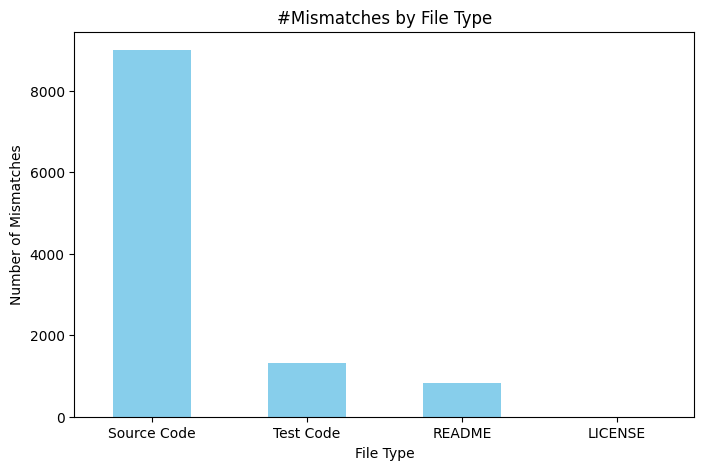

In [21]:
csv_file = "consolidated.csv"
df = pd.read_csv(csv_file)

def classify_file(row):
    if pd.notna(row['new_file_path']):
        file_path = row['new_file_path']
    else:
        file_path = row['old_file_path']
    
    if not file_path:
        return 'Other'
    
    file_path = file_path.lower()
    
    if file_path.endswith('.py') or file_path.endswith('.java') or file_path.endswith('.c') \
       or file_path.endswith('.cpp') or file_path.endswith('.js') or file_path.endswith('.ts'):
        return 'Source Code'
    else:
        if 'test' in file_path or file_path.endswith('_test.py') or file_path.endswith('test.java'):
            return 'Test Code'
        else:
            if 'readme' in file_path:
                return 'README'
            else:
                if 'license' in file_path:
                    return 'LICENSE'
                else:
                    return 'Other'

mismatch_df = df[df['Discrepancy'] == "Yes"]

mismatch_counts = mismatch_df.apply(classify_file, axis=1).value_counts()
categories = ['Source Code', 'Test Code', 'README', 'LICENSE']
mismatch_counts = mismatch_counts.reindex(categories, fill_value=0)

print("Mismatch counts by file type:")
print(mismatch_counts)

plt.figure(figsize=(8,5))
mismatch_counts.plot(kind='bar', color='skyblue')
plt.title("#Mismatches by File Type")
plt.xlabel("File Type")
plt.ylabel("Number of Mismatches")
plt.xticks(rotation=0)
plt.show()
